## **Generating Tabular Data using GANs**

Generative Adversarial Networks are type of unsupervised machine learning method which try to generate new, synthetic instances of data that mimics the real data. They are extremely popular in image, video (Deepfake) and voice generation. Generating tabular data using GANs isn't as popular as generating images, but can still produce some pretty good results. This notebook tries to do just that. GANs are constructed of two neural networks: Generator and Discriminator. Generator, using some random noise as input, tries to mimic the real data and Discriminator tries to classify the data into real and fake. It could be said that they are eachothers enemies. Both Neural Networks (Generator and Discriminator) are trained separately through backpropagation with regards to their loss.

## **Conditional GAN**

Conditional GAN or cGAN is a type of Generative Adversarial Network which adds the label y as an additional parameter to the generator in hope that the corresponding data will be generated. The labels are also added to the discriminator input to distinguish real data better.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle

np.random.seed(1635848)

First dataset has 20 features including one class that we will try to predict (label). Dataset contains a lot of untidy features that need some preprocessing before feeding it into the algorithm.

In [2]:
data = pd.read_csv('master_3lakh.csv')

In [3]:
# Duplicates? Yes

normal_duplicates = sum( data.loc[ data.label==0 ].duplicated() )
fraud_duplicates = sum( data.loc[ data.label==1 ].duplicated() )
total_duplicates = normal_duplicates + fraud_duplicates

print( 'Normal duplicates', normal_duplicates )
print( 'Fraud duplicates', fraud_duplicates )
print( 'Total duplicates', total_duplicates )
print( 'Fraction duplicated', total_duplicates / len(data) )

Normal duplicates 0
Fraud duplicates 0
Total duplicates 0
Fraction duplicated 0.0


In [4]:
# several columns heavily skewed, 'label' the highest (besides Class) ..Best value should be in between [-1,1]

data.skew()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


Unnamed: 0    -0.002965
L1             5.941209
L2             7.421356
L3             0.037613
L4             8.432541
L5             1.916166
L6             1.887193
L7             5.800135
L8             6.284124
L9             2.784055
D1             4.977041
D2             0.688985
H1             1.550992
E1             1.143988
E2             0.569535
E3             1.731593
E4             1.797490
E5             0.311634
F1             1.712344
label         62.001553
dtype: float64

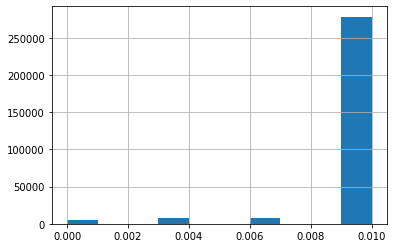

In [5]:
# Looks like all 'Amount' values are rounded to the hundredths (0.01) place
data['L2'].mod(0.01).hist() ;

In [6]:
# Some values are much more frequent than others
# 0.00 comes in 12th in the list

print( data.L2.value_counts().head(15) )

60.0     4553
120.0    4089
45.0     3752
135.0    3006
121.0    2995
30.0     2972
61.0     2892
15.0     2713
122.0    2689
90.0     2615
46.0     2604
75.0     2550
62.0     2500
47.0     2426
165.0    2373
Name: L2, dtype: int64


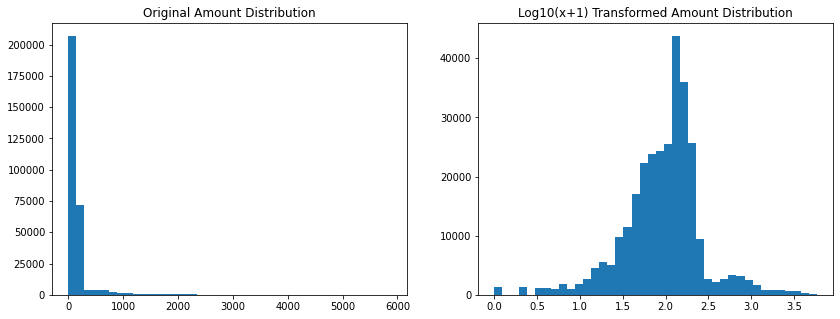

In [7]:
# Log transform amount values to give more normal distribution

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(data['L2'], bins=40)
plt.title('Original Amount Distribution')

plt.subplot(1,2,2)
d0 = np.log10( data['L2'].values + 1 )
# d0 = np.log1p( data['Amount'].values ) / np.log(10)
plt.hist( d0, bins=40 )
plt.title('Log10(x+1) Transformed Amount Distribution')
plt.show()

In [8]:
# # Use log transformed data

# data['L2'] = d0

In [9]:
data.isnull().sum()

Unnamed: 0         0
date               0
user               0
L1                63
L2                63
L3                63
L4                63
L5                63
L6                63
L7                63
L8                63
L9                63
D1            256899
D2            256899
H1               645
E1              2652
E2              2652
E3              2652
E4              2652
E5              2652
F1            233093
label              0
dtype: int64

In [10]:
data.drop(columns=['Unnamed: 0','D1','D2','F1'],axis=1,inplace=True)

In [11]:
data.isnull().sum()

date        0
user        0
L1         63
L2         63
L3         63
L4         63
L5         63
L6         63
L7         63
L8         63
L9         63
H1        645
E1       2652
E2       2652
E3       2652
E4       2652
E5       2652
label       0
dtype: int64

In [12]:
data = data.fillna(0)

In [13]:
data.isnull().sum()

date     0
user     0
L1       0
L2       0
L3       0
L4       0
L5       0
L6       0
L7       0
L8       0
L9       0
H1       0
E1       0
E2       0
E3       0
E4       0
E5       0
label    0
dtype: int64

In [14]:
# Add column for year
data["Year"] = pd.to_datetime(data["date"], format="%Y-%m-%d").dt.year

# Add column for day
data["Day"] = pd.to_datetime(data["date"], format="%Y-%m-%d").dt.day

data["month"] = pd.to_datetime(data["date"], format="%Y-%m-%d").dt.month

In [15]:
data.drop('date',axis=1,inplace=True)

In [16]:
data.head(2)

,user,L1,L2,L3,L4,L5,L6,L7,L8,L9,H1,E1,E2,E3,E4,E5,label,Year,Day,month
0,QWL3474,357.150000,150.00,0.333333,0.0,1.0,1.0,76.0,12.0,169.050000,83.0,13.0,29.0,4.0,3404386.0,42.0,0,2011,4,2
1,TJB0540,710.133333,382.35,0.000000,0.0,0.0,0.0,85.0,0.0,218.496667,12.0,7.0,15.0,12.0,9018108.0,22.0,0,2011,1,2


In [17]:
data.drop('user',axis=1,inplace=True)

In [18]:
data['label'].value_counts()

0    300000
1        78
Name: label, dtype: int64

In [19]:
data.columns

Index(['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'H1', 'E1', 'E2',
       'E3', 'E4', 'E5', 'label', 'Year', 'Day', 'month'],
      dtype='object')

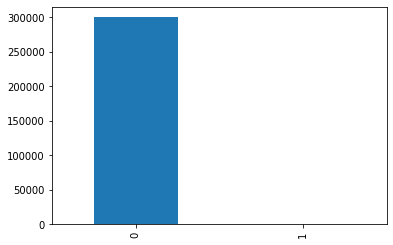

In [20]:
pd.value_counts(data['label']).plot.bar()

In [21]:
from sklearn.preprocessing import StandardScaler
data[['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'H1', 'E1', 'E2',
       'E3', 'E4', 'E5', 'Year', 'Day', 'month']] = StandardScaler().fit_transform(data[['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'H1', 'E1', 'E2',
       'E3', 'E4', 'E5', 'Year', 'Day', 'month']])

In [22]:
x = data.drop('label', axis=1).values
y = data.label.values

In [23]:
#train-test split
from sklearn.model_selection import train_test_split 
X_train,X_test,y_train,y_test=train_test_split( x, y, test_size=0.20, random_state=0)

In [24]:
(y_test==0).sum(),(y_test==1).sum(),(y_train==1).sum()

(59997, 19, 59)

In [25]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(x, y)

In [26]:
X_train1,X_test1,y_train1,y_test1 = train_test_split(X_sm, y_sm, test_size=0.20, random_state=0)
X_train1.shape,X_test1.shape,y_train1.shape,y_test1.shape

((480000, 18), (120000, 18), (480000,), (120000,))

In [27]:
(y_test1==0).sum(),(y_test1==1).sum()

(59856, 60144)

In [28]:
class cGAN():
    
    """
    Class containing 3 methods (and __init__): generator, discriminator and train.
    Generator is trained using random noise and label as inputs. Discriminator is trained
    using real/fake samples and labels as inputs.
    """
    
    def __init__(self,latent_dim=32, out_shape=18):
        
        self.latent_dim = latent_dim
        self.out_shape = out_shape 
        self.num_classes = 2
        # using Adam as our optimizer
        optimizer = Adam(0.0002, 0.5)
        
        # building the discriminator
        self.discriminator = self.discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # building the generator
        self.generator = self.generator()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])
        
        # we don't train discriminator when training generator
        self.discriminator.trainable = False
        valid = self.discriminator([gen_samples, label])

        # combining both models
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer,
                             metrics=['accuracy'])


    def generator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        
        model_input = multiply([noise, label_embedding])
        gen_sample = model(model_input)

        return Model([noise, label], gen_sample, name="Generator")

    
    def discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(512, input_dim=self.out_shape, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(256, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Dense(128, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Dense(1, activation='sigmoid'))
        
        gen_sample = Input(shape=(self.out_shape,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))

        model_input = multiply([gen_sample, label_embedding])
        validity = model(model_input)

        return Model(inputs=[gen_sample, label], outputs=validity, name="Discriminator")


    def train(self, X_train, y_train, pos_index, neg_index, epochs, sampling=False, batch_size=32, sample_interval=100, plot=True): 
        
        # though not recommended, defining losses as global helps as in analysing our cgan out of the class
        global G_losses
        global D_losses
        
        G_losses = []
        D_losses = []
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            
            # if sampling==True --> train discriminator with 8 sample from postivite class and rest with negative class
            if sampling:
                idx1 = np.random.choice(pos_index, 8)
                idx0 = np.random.choice(neg_index, batch_size-8)
                idx = np.concatenate((idx1, idx0))
            # if sampling!=True --> train discriminator using random instances in batches of 32
            else:
                idx = np.random.choice(len(y_train), batch_size)
            samples, labels = X_train[idx], y_train[idx]
            samples, labels = shuffle(samples, labels)
            
            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_samples = self.generator.predict([noise, labels])

            # label smoothing
            if epoch < epochs//1.5:
                valid_smooth = (valid+0.1)-(np.random.random(valid.shape)*0.1)
                fake_smooth = (fake-0.1)+(np.random.random(fake.shape)*0.1)
            else:
                valid_smooth = valid 
                fake_smooth = fake
                
            # Train the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)
            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            if (epoch+1)%sample_interval==0:
                print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, d_loss[0], g_loss[0]))
            G_losses.append(g_loss[0])
            D_losses.append(d_loss[0])
            if plot:
                if epoch+1==epochs:
                    plt.figure(figsize=(10,5))
                    plt.title("Generator and Discriminator Loss")
                    plt.plot(G_losses,label="G")
                    plt.plot(D_losses,label="D")
                    plt.xlabel("iterations")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.show()

In [29]:
data.columns

Index(['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'H1', 'E1', 'E2',
       'E3', 'E4', 'E5', 'label', 'Year', 'Day', 'month'],
      dtype='object')

## **Classifying using real trainset**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59856
           1       1.00      1.00      1.00     60144

    accuracy                           1.00    120000
   macro avg       1.00      1.00      1.00    120000
weighted avg       1.00      1.00      1.00    120000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


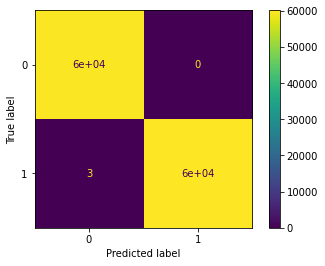

In [30]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train1, y_train1)

y_pred = lgb_1.predict(X_test1)

# evaluation
print(classification_report(y_test1, y_pred))
plot_confusion_matrix(lgb_1, X_test1, y_test1)
plt.show()

## **Training cGAN**

In [31]:
cgan = cGAN()

[99/500]	Loss_D: 0.6819	Loss_G: 0.6915
[199/500]	Loss_D: 0.5976	Loss_G: 0.8375
[299/500]	Loss_D: 0.4409	Loss_G: 1.0248
[399/500]	Loss_D: 0.3753	Loss_G: 1.4513
[499/500]	Loss_D: 0.2609	Loss_G: 1.7833


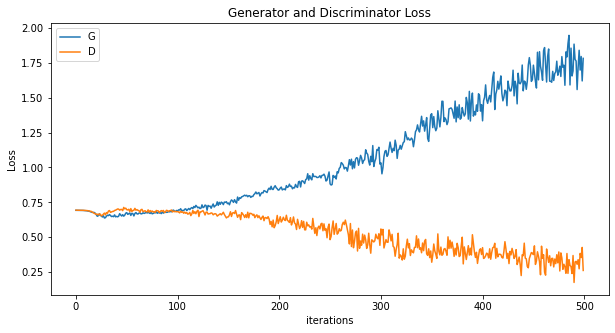

In [32]:
y_train1 = y_train1.reshape(-1,1)
pos_index = np.where(y_train1==1)[0]
neg_index = np.where(y_train1==0)[0]
cgan.train(X_train1, y_train1, pos_index, neg_index, epochs=500)

## **Generate Synthetic Data**

Will start to generate fake data using GANs. First step, we define a generate_latent_points function, it will create random noise in the latent space and be reshaped to the dimensions for matching the input of generator model.

In [33]:
noise = np.random.normal(0, 1, (19758, 32))
sampled_labels = np.zeros(19758).reshape(-1, 1)


gen_samples = cgan.generator.predict([noise, sampled_labels])

gen_df = pd.DataFrame(data = gen_samples,
                      columns = data.drop('label',1).columns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [34]:
# we want to generate 6290 instances with class value 1 since that represents how many 1s are in the label of the real training set
noise_2 = np.random.normal(0, 1, (6290, 32))
sampled_labels_2 = np.ones(6290).reshape(-1, 1)


gen_samples_2 = cgan.generator.predict([noise_2, sampled_labels_2])

gen_df_2 = pd.DataFrame(data = gen_samples_2,
                      columns = data.drop('label',1).columns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == '__main__':


## **Combining generated synthetic data into a dataframe**

In [35]:
gen_df_2['label'] = 1
gen_df['label']=0

df_gan = pd.concat([gen_df_2, gen_df], ignore_index=True, sort=False)
df_gan = df_gan.sample(frac=1).reset_index(drop=True)

X_train_2 = df_gan.drop('label', 1)
y_train_2 = df_gan['label'].values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


Classifying testset using generated trainset

              precision    recall  f1-score   support

           0       0.75      0.83      0.79     59856
           1       0.81      0.73      0.77     60144

    accuracy                           0.78    120000
   macro avg       0.78      0.78      0.78    120000
weighted avg       0.78      0.78      0.78    120000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


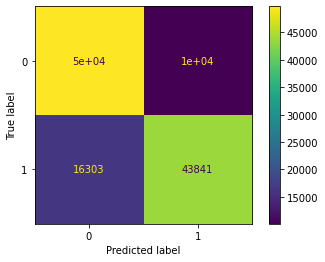

In [36]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train_2, y_train_2)


y_pred1 = lgb_1.predict(X_test1)

print(classification_report(y_test1, y_pred1))
plot_confusion_matrix(lgb_1, X_test1, y_test1)
plt.show()

In [37]:
# pip install catboost

              precision    recall  f1-score   support

           0       0.74      0.87      0.80     59856
           1       0.84      0.69      0.76     60144

    accuracy                           0.78    120000
   macro avg       0.79      0.78      0.78    120000
weighted avg       0.79      0.78      0.78    120000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


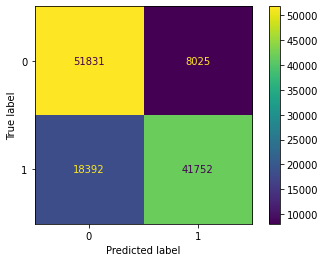

In [38]:
from catboost import CatBoostClassifier

model= CatBoostClassifier(iterations=1000, 
                         depth=5,
                         learning_rate=0.1,
                         eval_metric='AUC',
                         l2_leaf_reg=10,
                         metric_period=50,
                         thread_count=32,
                         random_seed=42)
model.fit(X_train_2, y_train_2,
          verbose=False)

y_pred2 = model.predict(X_test1)

print(classification_report(y_test1, y_pred2))
plot_confusion_matrix(model, X_test1, y_test1)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


              precision    recall  f1-score   support

           0       0.50      0.99      0.66     59856
           1       0.00      0.00      0.00     60144

    accuracy                           0.50    120000
   macro avg       0.25      0.50      0.33    120000
weighted avg       0.25      0.50      0.33    120000



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


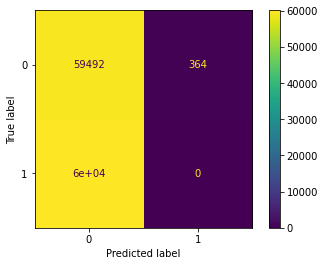

In [39]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train_2, y_train_2)
y_pred3 = clf.predict(X_test1)

print(classification_report(y_test1, y_pred3))
plot_confusion_matrix(clf, X_test1, y_test1)
plt.show()

In [40]:
# !pip install table_evaluator

In [41]:
data.head(5) # Real data

,L1,L2,L3,L4,L5,L6,L7,L8,L9,H1,E1,E2,E3,E4,E5,label,Year,Day,month
0,0.641816,-0.054011,0.410045,-0.131091,0.609015,0.608043,0.244103,-0.076016,0.920029,3.725511,1.795242,2.574895,0.104891,-0.000316,2.781750,0,1.584444,-1.325646,-1.021590
1,1.760059,0.648668,-1.046137,-0.131091,-0.935307,-0.891331,0.305365,-0.177530,1.568743,-0.448816,0.445164,0.660236,2.095805,1.472623,0.705679,0,1.584444,-1.671569,-1.021590
2,-0.483291,-0.353410,1.138136,-0.131091,0.609015,0.608043,-0.266417,-0.169070,-0.950152,-0.037263,1.345216,-0.160332,-0.143973,-0.069688,0.498071,0,-0.631136,-0.403186,-0.427351
3,0.668374,0.828005,0.045999,-0.131091,0.609015,0.608043,-0.096244,-0.143692,1.349637,-0.507610,-0.454888,1.891088,1.349212,1.052806,1.224696,0,1.584444,1.557043,-0.724471
4,0.561772,0.036716,0.410045,-0.131091,0.609015,0.608043,-0.123472,-0.126773,0.940729,0.315497,-0.454888,-0.433855,0.353756,0.958693,-0.539965,0,1.584444,0.288660,-0.427351


In [42]:
df_gan.head(5) # Fake Data

,L1,L2,L3,L4,L5,L6,L7,L8,L9,H1,E1,E2,E3,E4,E5,Year,Day,month,label
0,0.785023,-0.112402,1.000000,-0.816212,1.000000,1.000000,-0.245782,-0.866688,1.000000,0.322688,-0.999988,-0.984409,-1.000000,-1.000000,-0.999993,-0.755430,-0.187542,-0.992263,0
1,-0.053463,0.995321,0.999890,-0.990497,0.997962,0.998640,0.894954,0.005733,0.999405,-0.984107,-0.979749,-0.992681,-1.000000,-1.000000,-1.000000,-0.997633,-0.714669,0.769546,0
2,-0.127741,0.987771,-0.999974,-0.996725,-0.999613,-0.993057,0.954598,0.128845,-0.999995,-0.999495,-0.865393,-0.999005,-0.990986,-0.978455,-0.999998,-0.957896,0.650543,0.985981,1
3,-0.511502,0.999943,-0.999999,-0.999840,-0.999997,-0.999287,-0.825960,-0.371485,-0.999985,-0.999960,-0.999756,-0.999999,-0.997438,-0.999106,-0.999992,-0.524368,0.363887,0.727686,1
4,0.483612,0.999684,1.000000,-0.997412,1.000000,1.000000,-0.999785,-0.731994,1.000000,0.999896,-1.000000,-0.950516,-1.000000,-1.000000,-1.000000,-0.999997,-0.957007,-0.489507,0


In [43]:
cat_cols = ['L1','L2','L3']

In [44]:
# pip install table-evaluator

In [45]:
from table_evaluator import load_data, TableEvaluator
table_evaluator = TableEvaluator(data, df_gan, cat_cols=cat_cols)
#table_evaluator.evaluate(target_col=cat_cols)

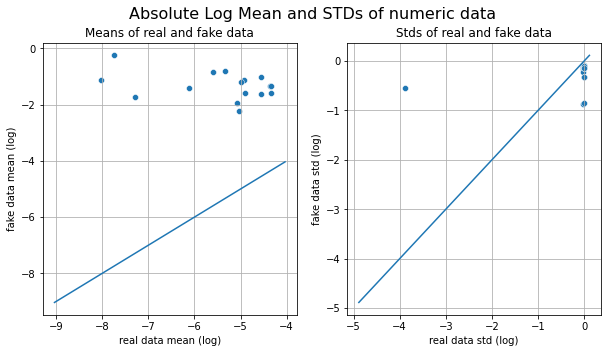

In [ ]:
table_evaluator.visual_evaluation()